In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow import keras

# Visualizar datos

In [2]:
df_1 = pd.read_csv(r'train_diploF.csv')
df_1 = df_1.drop("ID", axis=1)
df_1['y'].replace({"yes": 1, "no": 0}, inplace=True)

In [3]:
df_1

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,29,technician,single,tertiary,no,18254,no,no,cellular,11,may,2,-1,0,unknown,0
1,26,services,single,secondary,no,512,yes,yes,unknown,5,jun,3,-1,0,unknown,0
2,30,management,single,secondary,no,135,no,no,cellular,14,aug,2,-1,0,unknown,0
3,41,technician,married,unknown,no,30,yes,no,cellular,10,jul,1,-1,0,unknown,0
4,27,admin.,single,secondary,no,321,no,yes,unknown,2,sep,1,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12865,47,technician,married,secondary,no,1167,yes,no,cellular,30,apr,1,87,5,failure,1
12866,31,unknown,married,secondary,no,111,no,no,cellular,21,nov,2,93,2,failure,1
12867,37,unemployed,single,tertiary,no,1316,yes,no,cellular,18,nov,1,172,2,failure,0
12868,42,management,married,tertiary,no,479,yes,no,unknown,28,may,2,-1,0,unknown,0


In [65]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12870 entries, 0 to 12869
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        12870 non-null  int64 
 1   job        12870 non-null  object
 2   marital    12870 non-null  object
 3   education  12870 non-null  object
 4   default    12870 non-null  object
 5   balance    12870 non-null  int64 
 6   housing    12870 non-null  object
 7   loan       12870 non-null  object
 8   contact    12870 non-null  object
 9   day        12870 non-null  int64 
 10  month      12870 non-null  object
 11  campaign   12870 non-null  int64 
 12  pdays      12870 non-null  int64 
 13  previous   12870 non-null  int64 
 14  poutcome   12870 non-null  object
 15  y          12870 non-null  int64 
dtypes: int64(7), object(9)
memory usage: 1.6+ MB


In [3]:
df_1.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [77]:
columnas_traducidas = ["Edad", "Ocupación", "Estado civil", "Educación", "Incumplimiento de pago", "Saldo", "Préstamo vivienda", "Préstamo personal", "Método contacto", "Día", "Mes", "Campaña", "Días último contacto", "Contactos previos", "Resultado anterior", "Etiqueta"]
df_1.columns = columnas_traducidas

In [84]:
df_1['Resultado anterior'].value_counts()

unknown    10070
failure     1380
success      845
other        575
Name: Resultado anterior, dtype: int64

# Valores faltantes

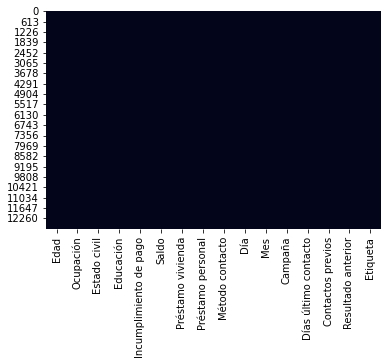

In [78]:
sns.heatmap(df_1.isnull(), cbar=False)
plt.show()

In [79]:
# Define el valor específico que deseas eliminar
condition = df['Resultado anterior'] == 'other'

# Step 2: Use the condition to drop the rows and create a new DataFrame
df = df.drop(df[condition].index, axis=0, inplace=False)

In [80]:
df[['Ocupación','Educación']] = df[['Ocupación','Educación']].replace(['unknown'],'other')

In [81]:
df = df.dropna(subset=['Ocupación'], how='any')

In [82]:
df['Resultado anterior'].value_counts()

unknown    10070
failure     1380
success      845
Name: Resultado anterior, dtype: int64

In [149]:
class IQRRemover:
    def __init__(self, dataframe, column_name, iqr_threshold=3.5):
        self.dataframe = dataframe.copy()
        self.column_name = column_name
        self.iqr_threshold = iqr_threshold

    def remove_outliers(self):
        column_data = self.dataframe[self.column_name]
        
        # Calculate the IQR (Interquartile Range)
        Q1 = column_data.quantile(0.25)
        Q3 = column_data.quantile(0.75)
        IQR = Q3 - Q1

        # Define the lower and upper bounds for outliers
        lower_bound = Q1 - self.iqr_threshold * IQR
        upper_bound = Q3 + self.iqr_threshold * IQR

        # Identify and remove outliers
        condition = (column_data >= lower_bound) & (column_data <= upper_bound)
        self.dataframe = self.dataframe[condition]

        return self.dataframe

In [153]:
iqr_remover = IQRRemover(df, 'Saldo', iqr_threshold=3.5)
df = iqr_remover.remove_outliers()

In [154]:
dataset3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11800 entries, 1 to 12869
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Edad                    11800 non-null  int64 
 1   Ocupación               11800 non-null  object
 2   Estado civil            11800 non-null  object
 3   Educación               11800 non-null  object
 4   Incumplimiento de pago  11800 non-null  object
 5   Saldo                   11800 non-null  int64 
 6   Préstamo vivienda       11800 non-null  object
 7   Préstamo personal       11800 non-null  object
 8   Método contacto         11800 non-null  object
 9   Día                     11800 non-null  int64 
 10  Mes                     11800 non-null  object
 11  Campaña                 11800 non-null  int64 
 12  Días último contacto    11800 non-null  int64 
 13  Contactos previos       11800 non-null  int64 
 14  Resultado anterior      11800 non-null  object
 15  Et

# Graficos

In [155]:
# DataFrame con datos categóricos
df_categoricos = df_rem.select_dtypes(include=['object']).copy()
# DataFrame con datos numéricos
df_numericos = df_rem.select_dtypes(exclude=['object']).copy()

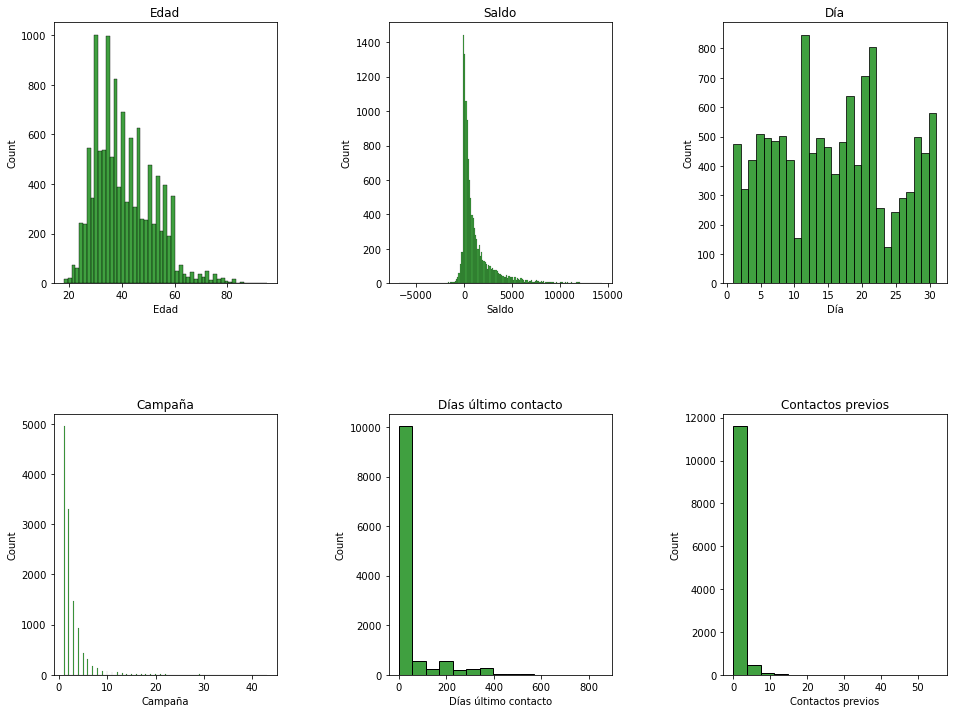

In [156]:
fig, ax = plt.subplots(2, 3, figsize=(16, 12))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for i, variable in enumerate(df_numericos):
    if i < 2 * 3:
        sns.histplot(data=df_numericos, x=variable, ax=ax[i//3, i%3], color="green")
        ax[i//3, i%3].set_title(variable)

plt.show()

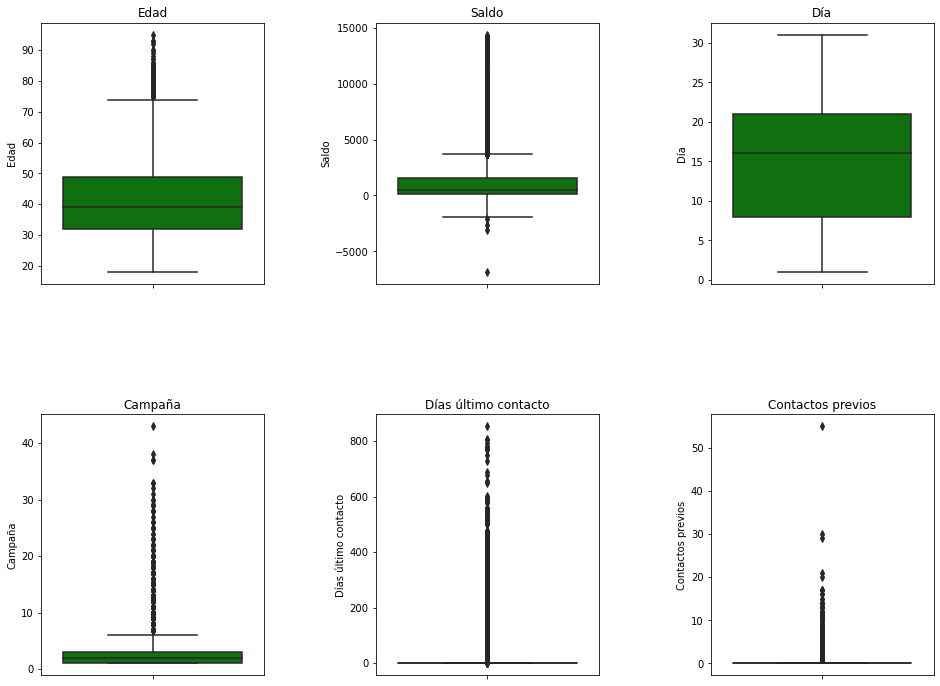

In [157]:
fig, ax = plt.subplots(2, 3, figsize=(16, 12))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for i, variable in enumerate(df_numericos):
    if i < 2 * 3:
        sns.boxplot(data=df_numericos, y=variable, ax=ax[i//3, i%3], color="green")
        ax[i//3, i%3].set_title(variable)

plt.show()

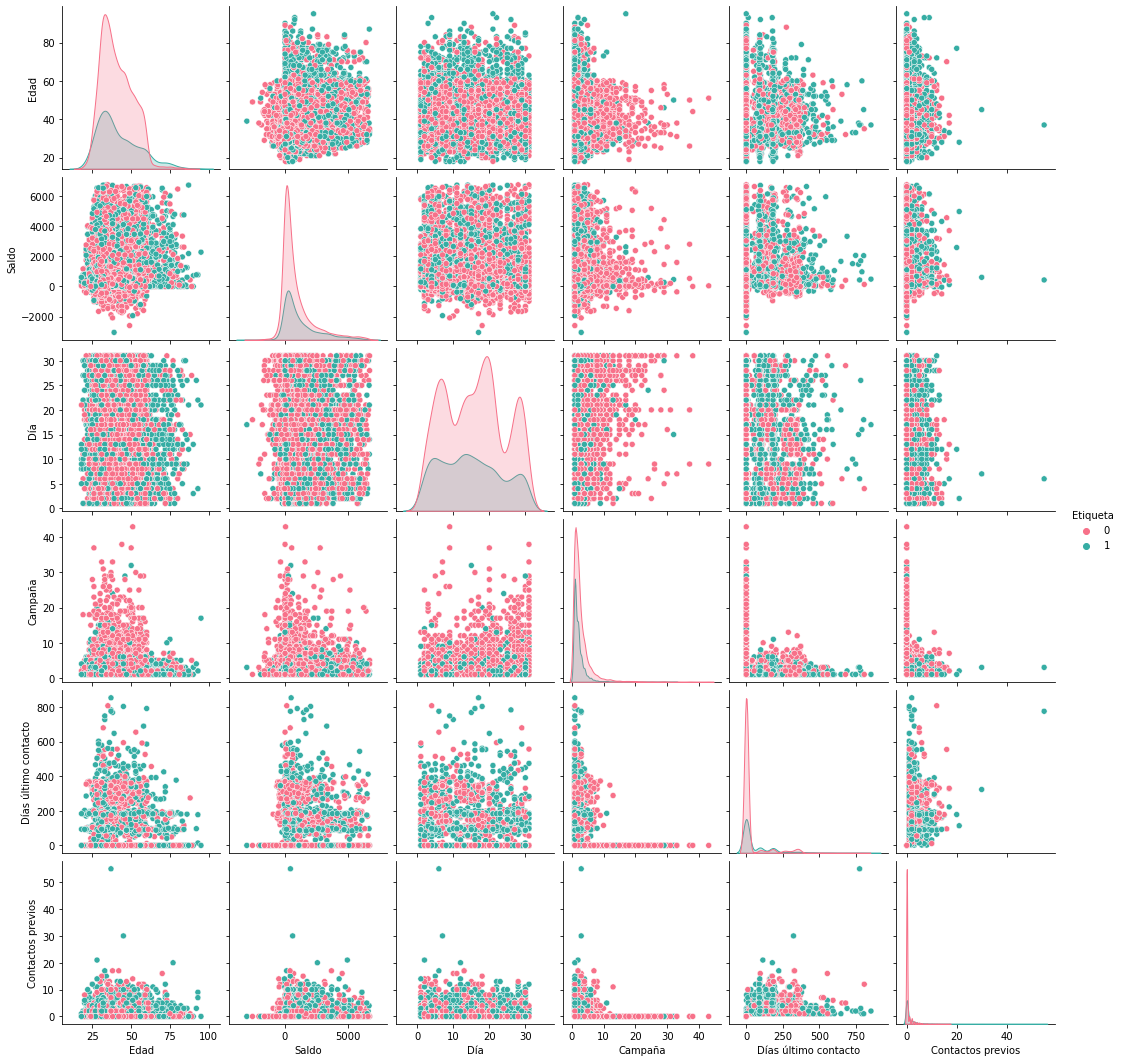

In [158]:
sns.pairplot(df, hue="Etiqueta", palette="husl")
plt.show()

# Funciones auxiliares

In [163]:
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

def remove_labels(df, label_name):
    X = df.drop(label_name, axis=1)
    y = df[label_name].copy()
    return (X, y)

def evaluate_result(y_pred, y, y_prep_pred, y_prep, metric):
    print(metric.__name__, "Para datos de train:", metric(y_pred, y, average='weighted'))
    print(metric.__name__, "Para datos de validacion:", metric(y_prep_pred, y_prep, average='weighted'))

In [164]:
train_set, val_set, test_set = train_val_test_split(df, stratify="Etiqueta")

In [165]:
X_train, y_train = remove_labels(train_set, 'Etiqueta')
X_val, y_val = remove_labels(val_set, 'Etiqueta')
X_test, y_test = remove_labels(test_set, 'Etiqueta')

In [166]:
print("Longitud del Training Set:", len(train_set))
print("Longitud del Validation Set:", len(val_set))
print("Longitud del Test Set:", len(test_set))

Longitud del Training Set: 7080
Longitud del Validation Set: 2360
Longitud del Test Set: 2360


# Preprocesamiento

## Dummificacion

In [167]:
# Transormador para codificar únicamente las columnas categoricas y devolver un DataFrame
class CustomOneHotEncoding(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._oh = OneHotEncoder(sparse=False)
        self._columns = None
    def fit(self, X, y=None):
        X_cat = X.select_dtypes(include=['object'])
        self._columns = pd.get_dummies(X_cat).columns
        self._oh.fit(X_cat)
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_cat = X_copy.select_dtypes(include=['object'])
        X_num = X_copy.select_dtypes(exclude=['object'])
        X_cat_oh = self._oh.transform(X_cat)
        X_cat_oh = pd.DataFrame(X_cat_oh, 
                                columns=self._columns, 
                                index=X_copy.index)
        X_copy.drop(list(X_cat), axis=1, inplace=True)
        return X_copy.join(X_cat_oh)

In [168]:
# Crear una instancia del transformador
custom_encoding = CustomOneHotEncoding()

X_train_dum = custom_encoding.fit_transform(X_train)
X_val_dum = custom_encoding.fit_transform(X_val)
X_test_dum = custom_encoding.fit_transform(X_test)

## Escalado

In [169]:
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.robust_scaler = RobustScaler()
        self.robust_scaler.fit(X)
        return self
    
    def transform(self, X, y=None):
        X_scaled = self.robust_scaler.transform(X)
        X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
        return X_scaled_df

In [170]:
custom_scaler = CustomScaler()
X_train_pro = custom_scaler.fit_transform(X_train_dum)
X_val_pro = custom_scaler.transform(X_val_dum)
X_test_pro = custom_scaler.transform(X_test_dum)

# Modelo

In [211]:
y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)

In [274]:
model = models.Sequential()

model.add(layers.Dense(128, activation='relu', input_shape=(X_train_pro.shape[1],)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(56, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

optimizer = keras.optimizers.Adam(learning_rate=0.00001)

model.compile(optimizer=optimizer,
             loss='huber_loss',
             metrics=['accuracy', 'Precision'])

In [276]:
history1 = model.fit(X_train_pro,
                   y_train,
                   epochs=30,
                   batch_size=16,
                   validation_data=(X_val_pro, y_val))

Epoch 1/30
443/443 [==============================] - 1s 2ms/step - loss: 0.1123 - accuracy: 0.7054 - precision: 0.5325 - val_loss: 0.0958 - val_accuracy: 0.7127 - val_precision: 0.7105
Epoch 2/30
443/443 [==============================] - 1s 3ms/step - loss: 0.1118 - accuracy: 0.7064 - precision: 0.5385 - val_loss: 0.1012 - val_accuracy: 0.7042 - val_precision: 0.8333
Epoch 3/30
443/443 [==============================] - 1s 2ms/step - loss: 0.1147 - accuracy: 0.7004 - precision: 0.5058 - val_loss: 0.0944 - val_accuracy: 0.7174 - val_precision: 0.5811
Epoch 4/30
443/443 [==============================] - 1s 2ms/step - loss: 0.1115 - accuracy: 0.7072 - precision: 0.5359 - val_loss: 0.0973 - val_accuracy: 0.7068 - val_precision: 0.5228
Epoch 5/30
443/443 [==============================] - 1s 2ms/step - loss: 0.1130 - accuracy: 0.7013 - precision: 0.5082 - val_loss: 0.1078 - val_accuracy: 0.7097 - val_precision: 0.5303
Epoch 6/30
443/443 [==============================] - 1s 2ms/step - lo

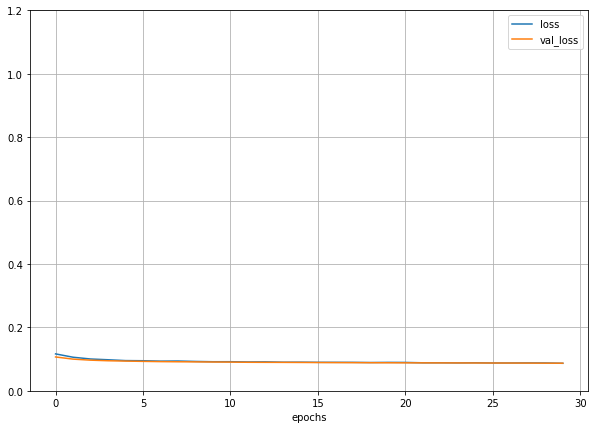

In [269]:
pd.DataFrame(history1.history)[['loss', 'val_loss']].plot(figsize=(10, 7))
plt.grid(True)
plt.gca().set_ylim(0, 1.2)
plt.xlabel("epochs")
plt.show()

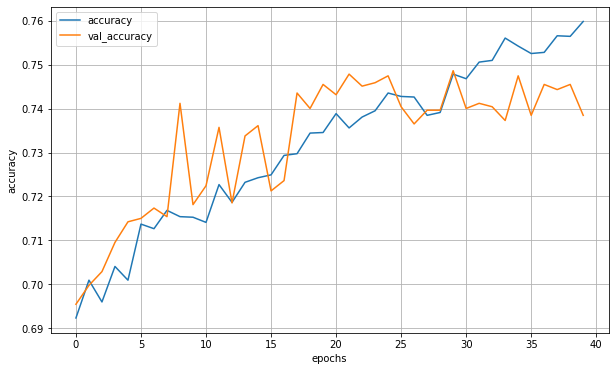

In [266]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

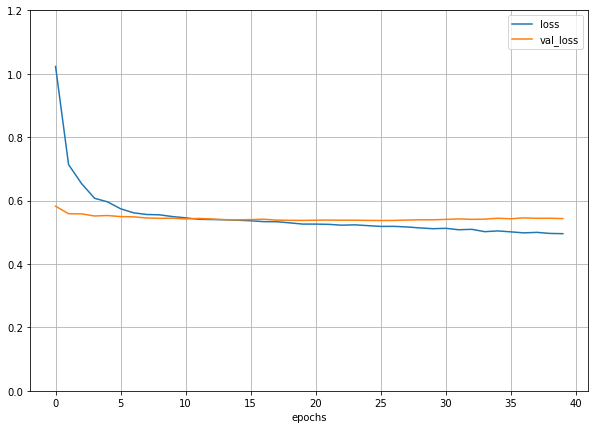

In [179]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(figsize=(10, 7))
plt.grid(True)
plt.gca().set_ylim(0, 1.2)
plt.xlabel("epochs")
plt.show()

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# Modelo entrenado con el conjunto de datos sin escalar
clf_rnd = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
clf_rnd.fit(X_train_pro, y_train)

RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)

In [37]:
y_train_pred = clf_rnd.predict(X_train)

ValueError: could not convert string to float: 'self-employed'